In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import time

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Set random seed for reproducibility
np.random.seed(42)

# Display settings for better readability
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.2)

In [2]:
print("Loading the datasets...")

# Define the paths to the datasets
train_path = '../resources/train.csv' 
test_path = '../resources/test.csv'
submission_path = '../resources/sample_submission.csv'

# Load the datasets
try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    sample_submission = pd.read_csv(submission_path)
    
    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Sample submission shape: {sample_submission.shape}")
except FileNotFoundError:
    print("Error: Data files not found. Please adjust the paths to match your file locations.")
    print("You might need to update the paths in this cell to point to where your CSV files are stored.")

Loading the datasets...
Training data shape: (58645, 13)
Test data shape: (39098, 12)
Sample submission shape: (39098, 2)


In [3]:
print("\n--- Training Data Information ---")
train_data.info()

print("\n--- Summary Statistics ---")
print(train_data.describe())

# Check for missing values
print("\n--- Missing Values in Training Data ---")
print(train_data.isnull().sum())

print("\n--- Missing Values in Test Data ---")
print(test_data.isnull().sum())

# Check the target variable distribution
print("\n--- Target Variable Distribution ---")
print(train_data['loan_status'].value_counts(normalize=True))


--- Training Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
d

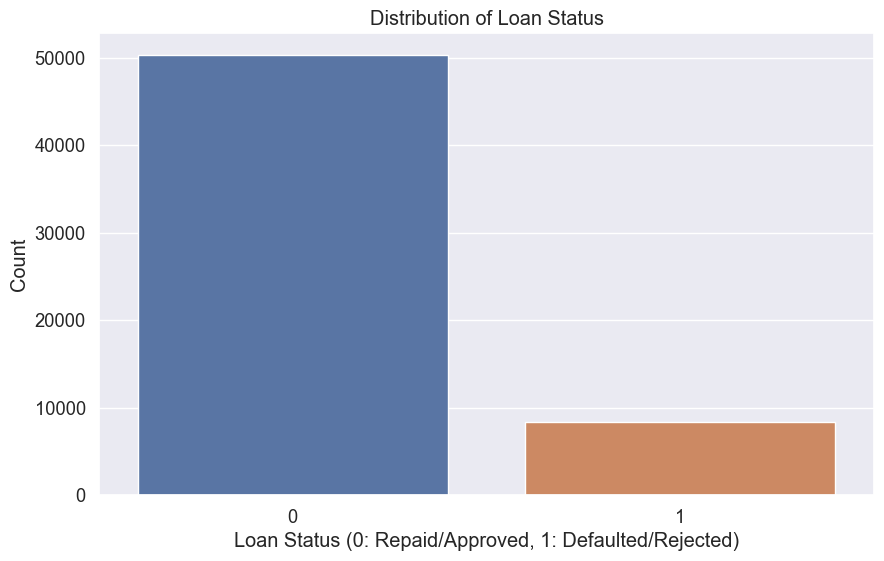

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=train_data)
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status (0: Repaid/Approved, 1: Defaulted/Rejected)')
plt.ylabel('Count')
plt.show()

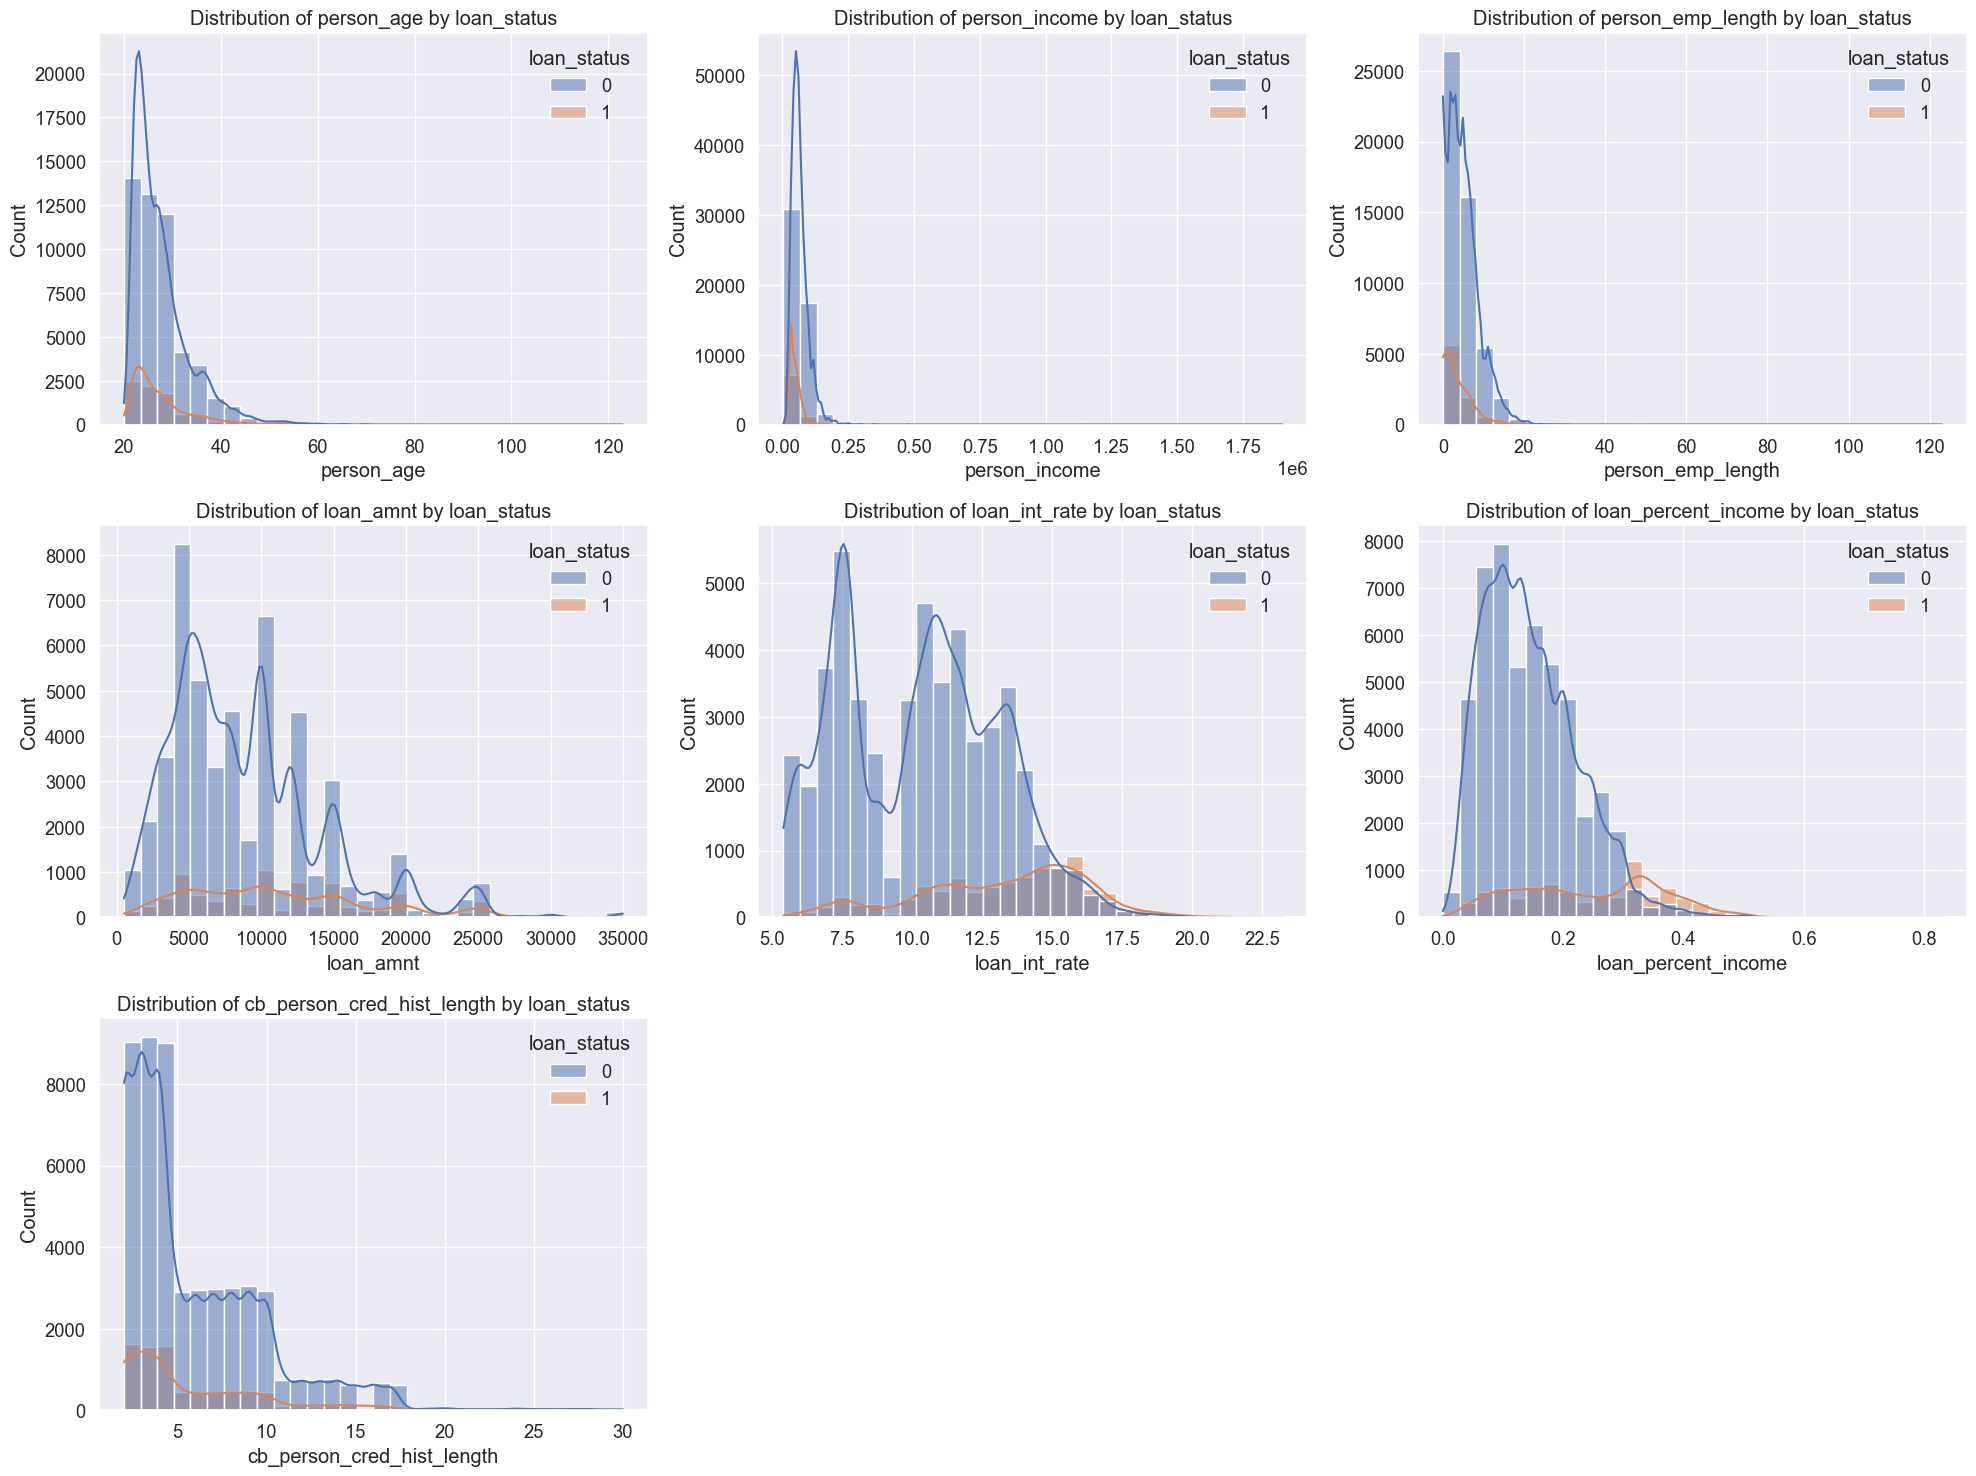

In [5]:
numerical_features = ['person_age', 'person_income', 'person_emp_length', 
                     'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                     'cb_person_cred_hist_length']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=train_data, x=feature, hue='loan_status', bins=30, kde=True)
    plt.title(f'Distribution of {feature} by loan_status')
plt.tight_layout()
plt.show()

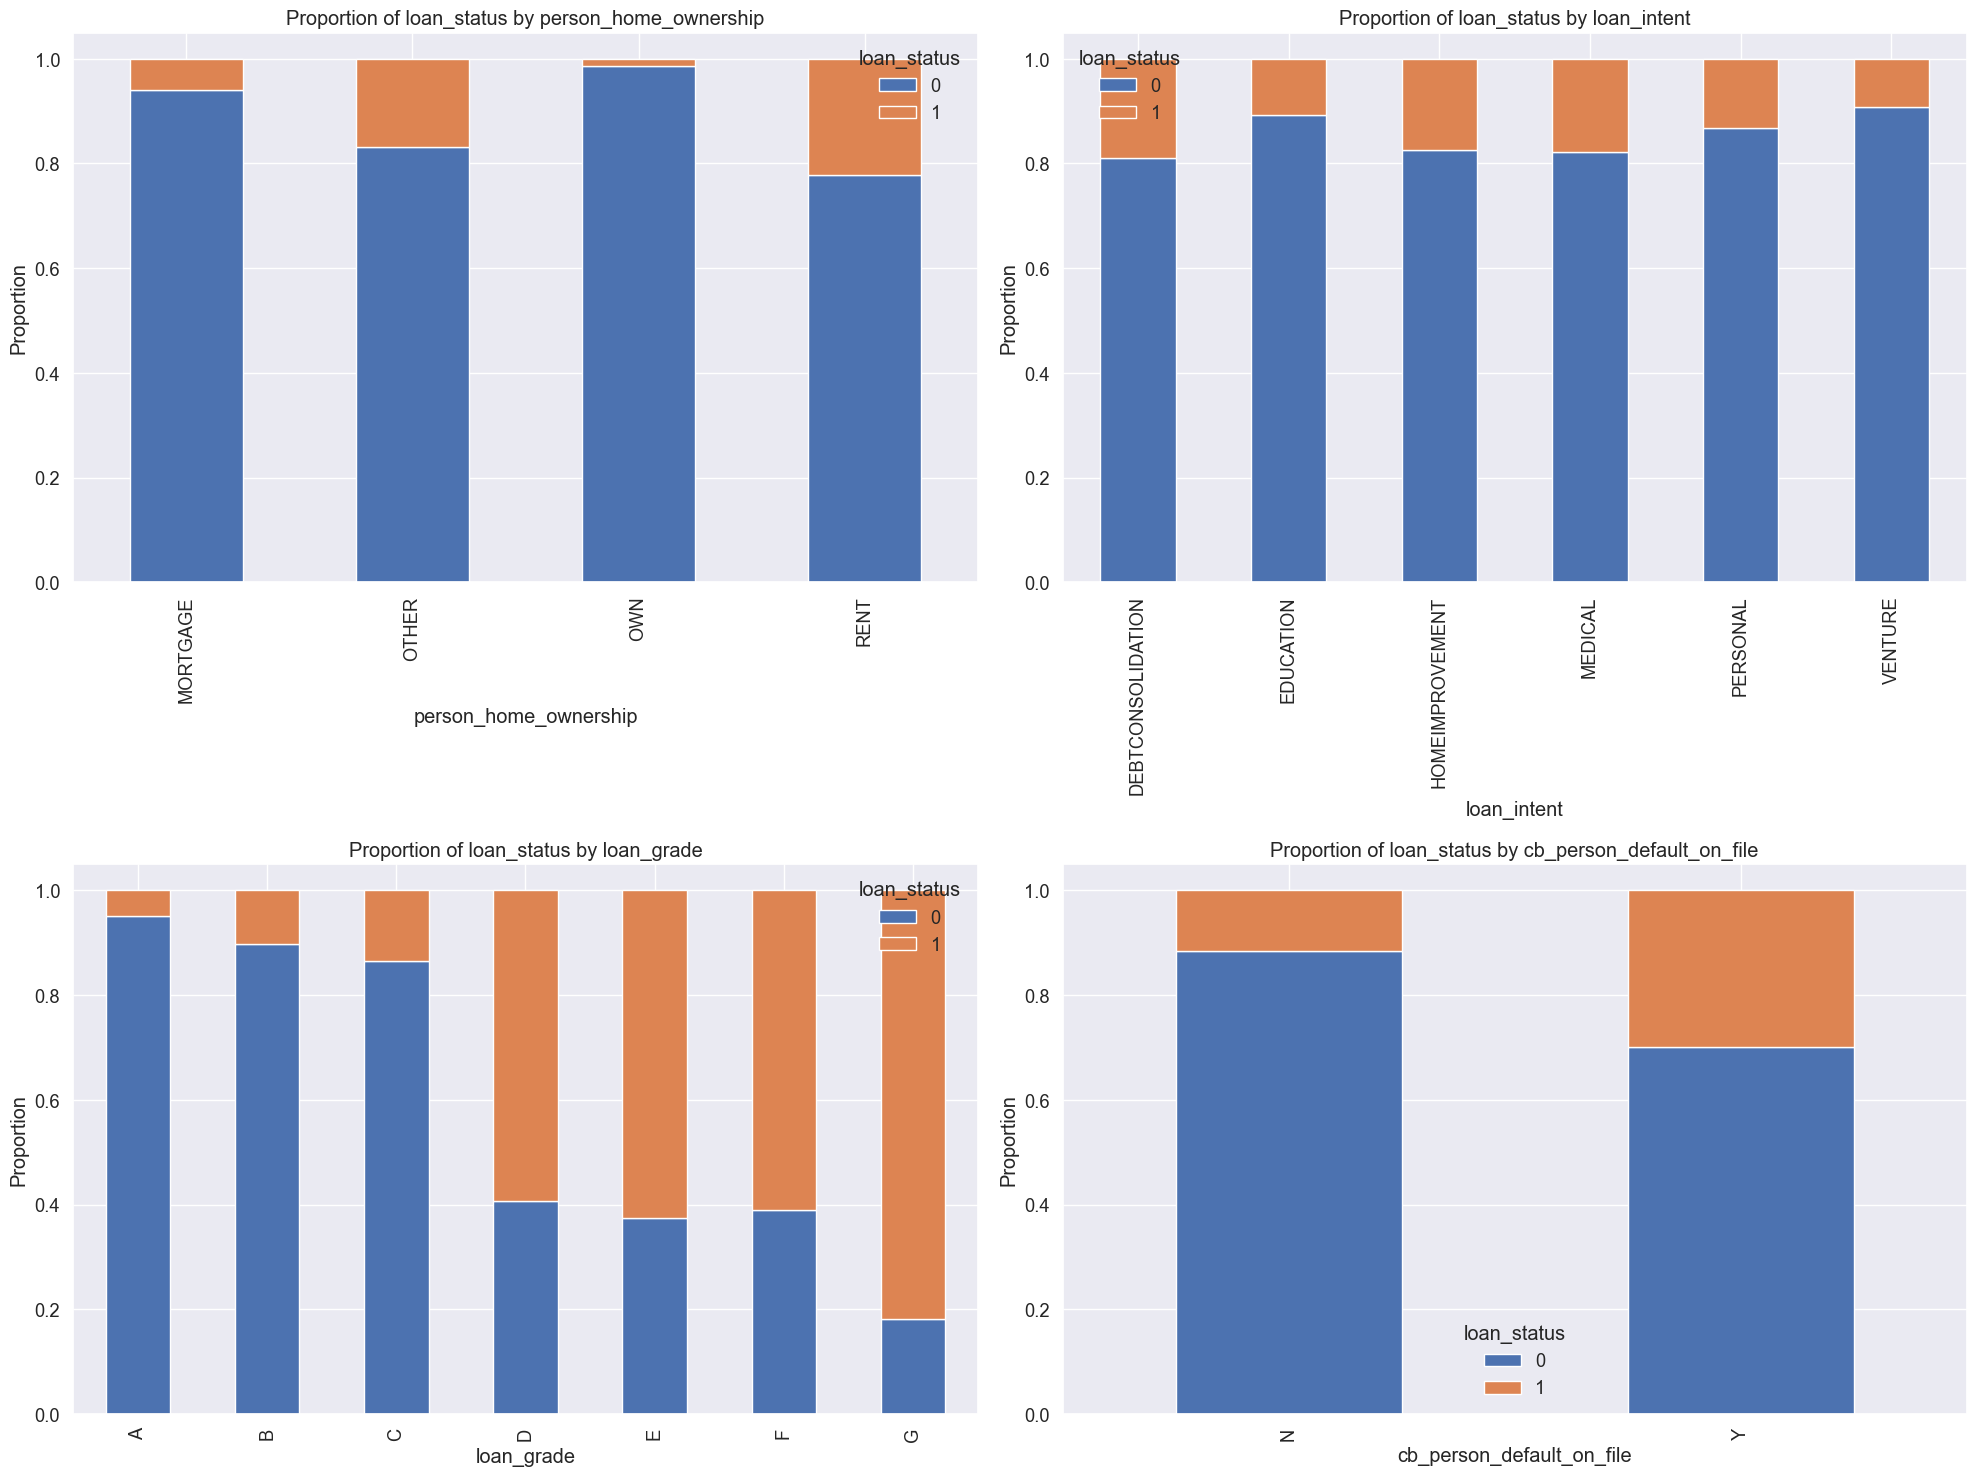

In [6]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

fig, axs = plt.subplots(2, 2, figsize=(20, 15))  # create all subplots at once

axs = axs.flatten()  # flatten 2D array of axes for easy indexing

for i, feature in enumerate(categorical_features):
    ct = pd.crosstab(train_data[feature], train_data['loan_status'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axs[i])  # specify the axis here
    axs[i].set_title(f'Proportion of loan_status by {feature}')
    axs[i].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

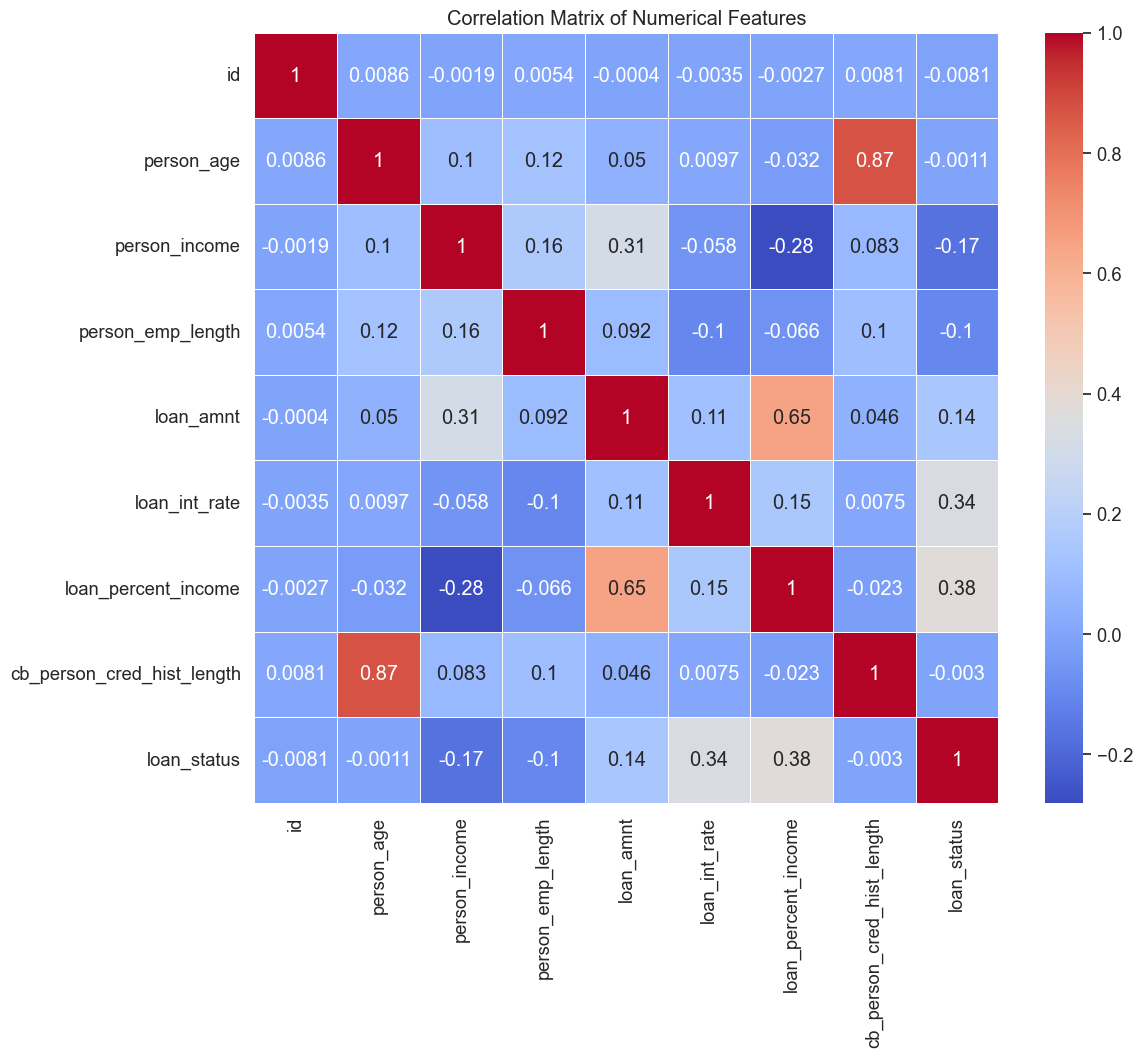

In [7]:
plt.figure(figsize=(12, 10))
correlation_matrix = train_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [8]:
# Separate features and target variable
X_train = train_data.drop(['loan_status', 'id'], axis=1)
y_train = train_data['loan_status']
X_test = test_data.drop(['id'], axis=1)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


Numerical features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical features: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [9]:
# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    #if model_name == 'SVM':
    #    X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train)
    #    model.fit(X_train_sub, y_train_sub)
    #else:
    #    model.fit(X_train, y_train)
    
    train_time = time.time() - start_time

    # Testing time
    start_time = time.time()
    y_pred = model.predict(X_val)
    test_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    # ROC Curve if the model supports predict_proba
    try:
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        has_roc = True
    except:
        has_roc = False
        roc_auc = None
        fpr, tpr = None, None

    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if has_roc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Training time: {train_time:.4f} seconds")
    print(f"Testing time: {test_time:.4f} seconds")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['0', '1'], 
                yticklabels=['0', '1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve if available
    if has_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Learning Curve
    #if model_name == 'SVM':
    #    print(f"Skipping learning curve for SVM due to high computational cost.") 
    #else:
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=3,       # ideal cv=5
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='f1', n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                        alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, label='Validation score', color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                        alpha=0.1, color='red')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'test_time': test_time
    }


Training Decision Tree...

--- Decision Tree Results ---
Accuracy: 0.9112
Precision: 0.6758
Recall: 0.7240
F1 Score: 0.6990
ROC AUC: 0.8331
Training time: 1.0933 seconds
Testing time: 0.0750 seconds


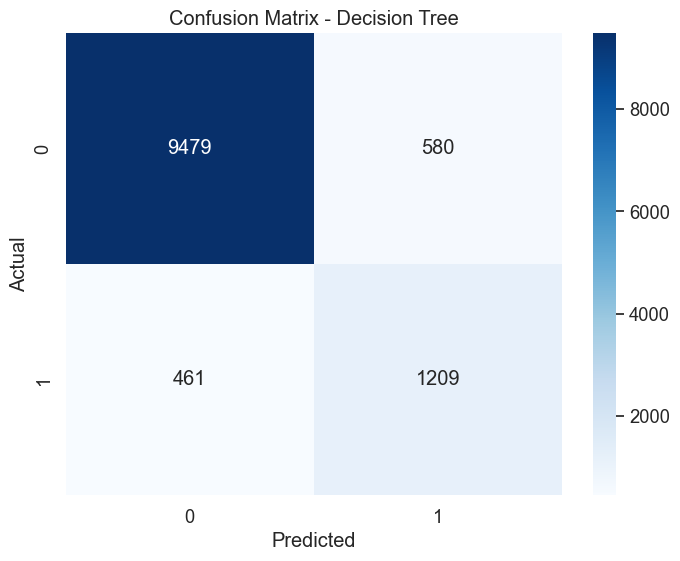

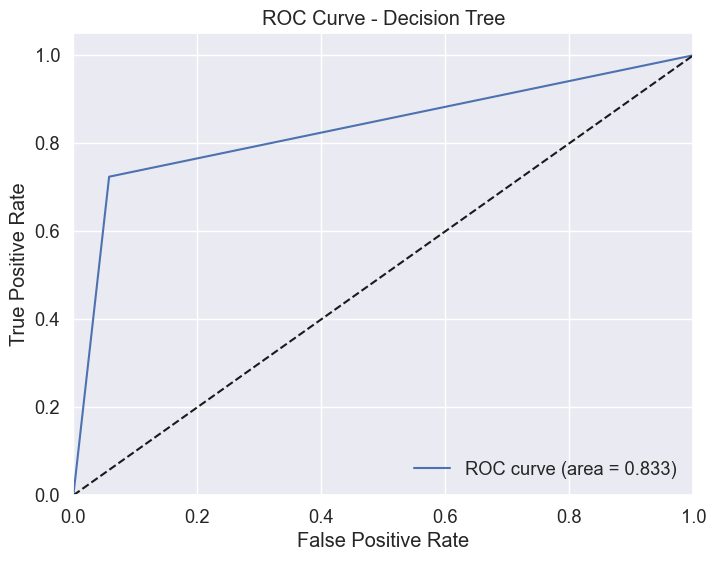

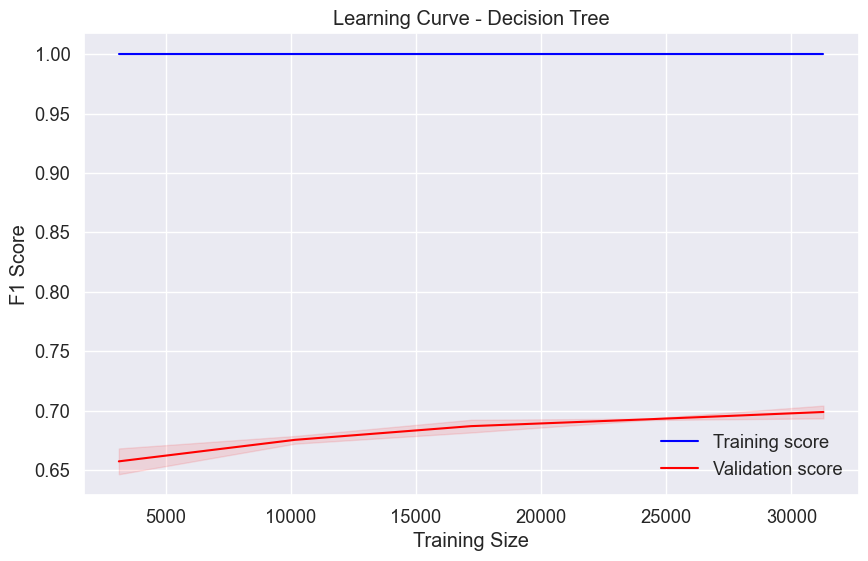


Training K-Nearest Neighbors...

--- K-Nearest Neighbors Results ---
Accuracy: 0.9317
Precision: 0.8403
Recall: 0.6425
F1 Score: 0.7282
ROC AUC: 0.8716
Training time: 0.2240 seconds
Testing time: 2.2550 seconds


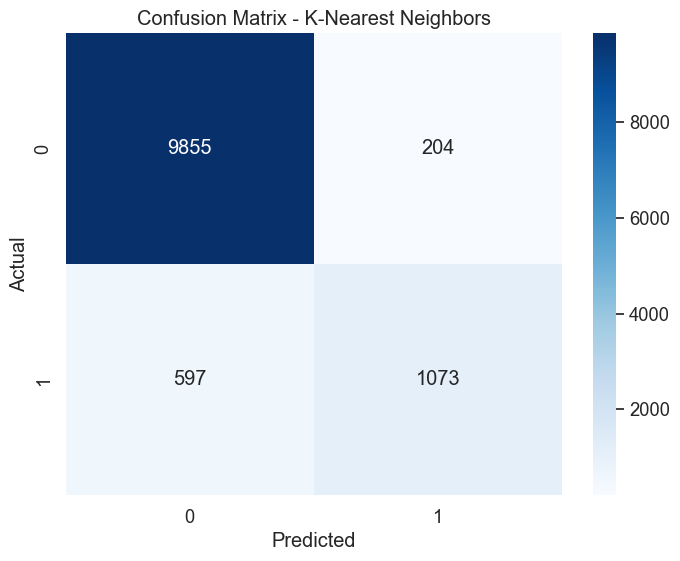

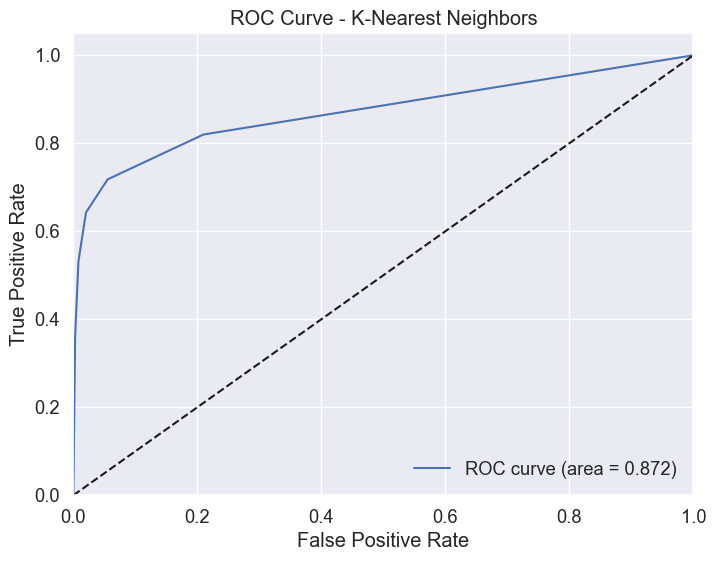

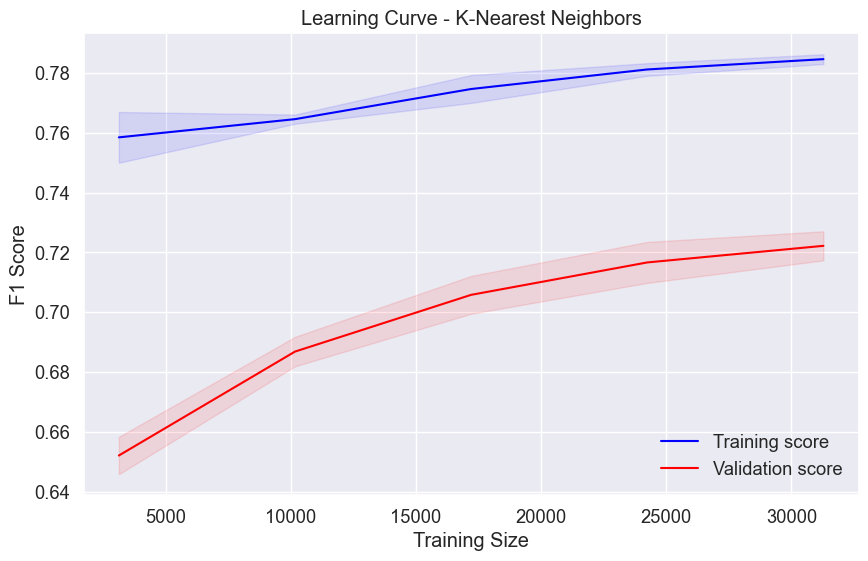


Training Random Forest...

--- Random Forest Results ---
Accuracy: 0.9507
Precision: 0.9292
Recall: 0.7078
F1 Score: 0.8035
ROC AUC: 0.9308
Training time: 16.2480 seconds
Testing time: 0.5030 seconds


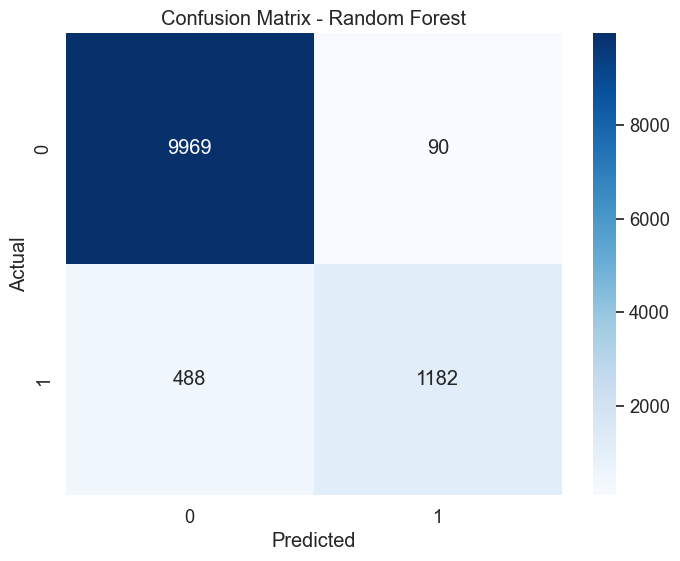

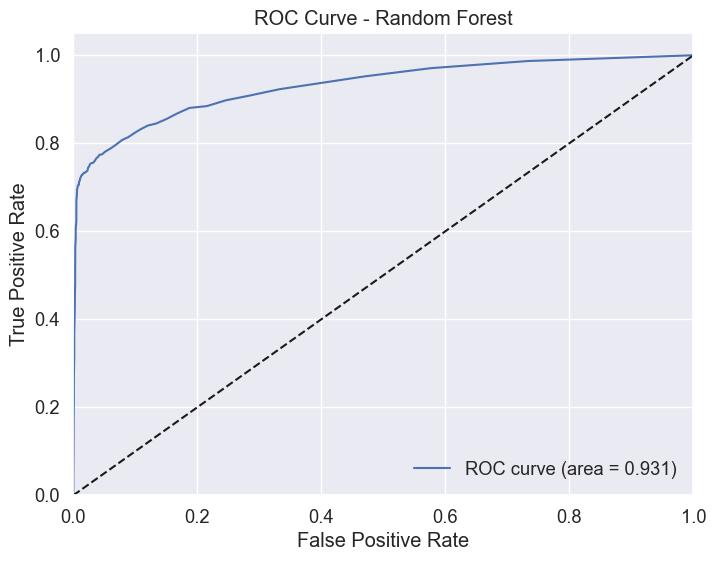

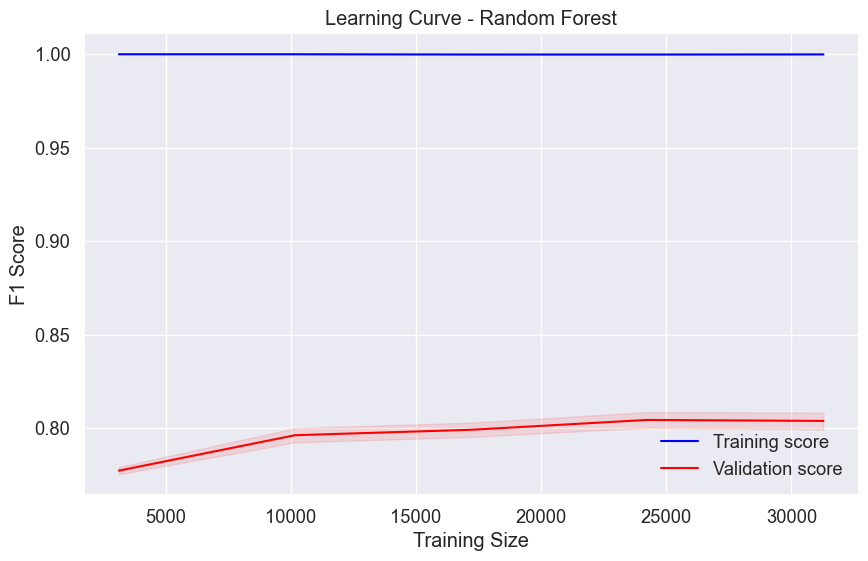


Training Neural Network...

--- Neural Network Results ---
Accuracy: 0.9453
Precision: 0.9079
Recall: 0.6850
F1 Score: 0.7809
ROC AUC: 0.9247
Training time: 47.3410 seconds
Testing time: 0.0460 seconds


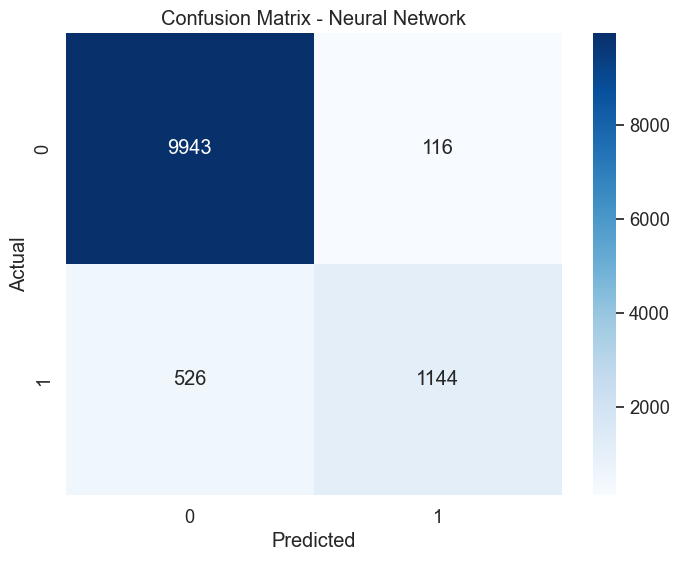

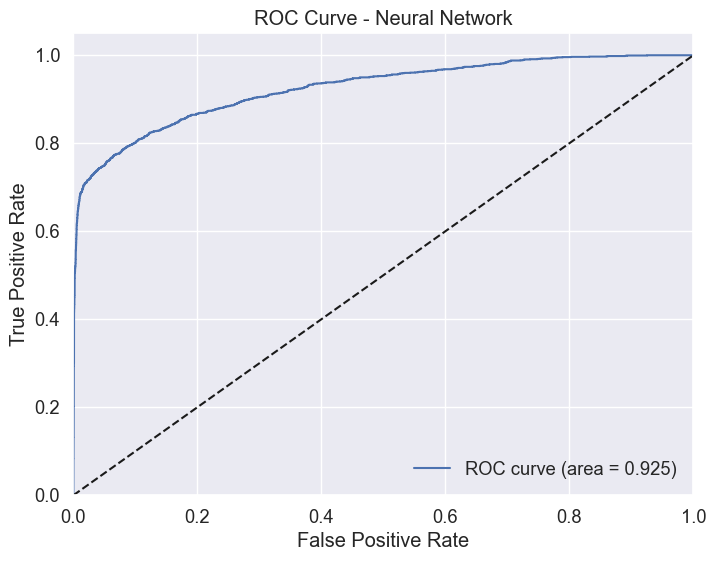

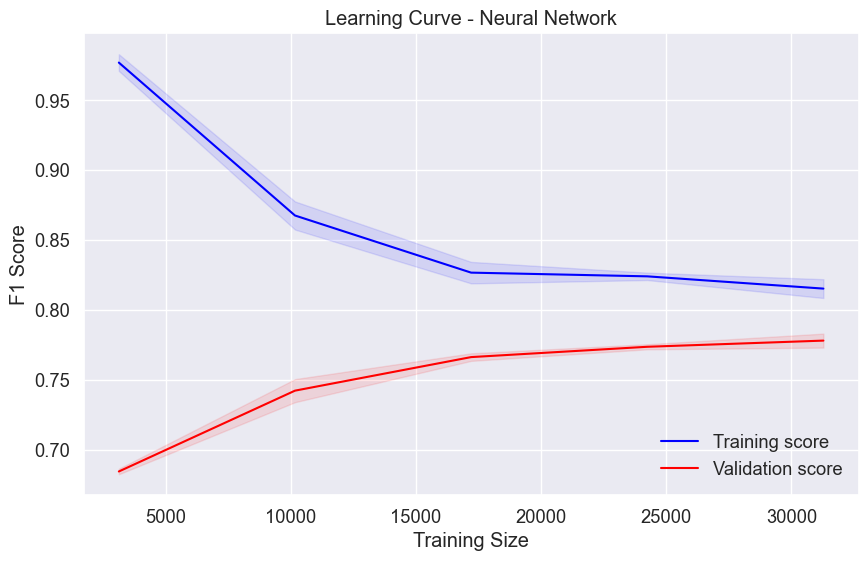


Training SVM...

--- SVM Results ---
Accuracy: 0.9439
Precision: 0.9141
Recall: 0.6689
F1 Score: 0.7725
ROC AUC: 0.8889
Training time: 542.2445 seconds
Testing time: 21.5230 seconds


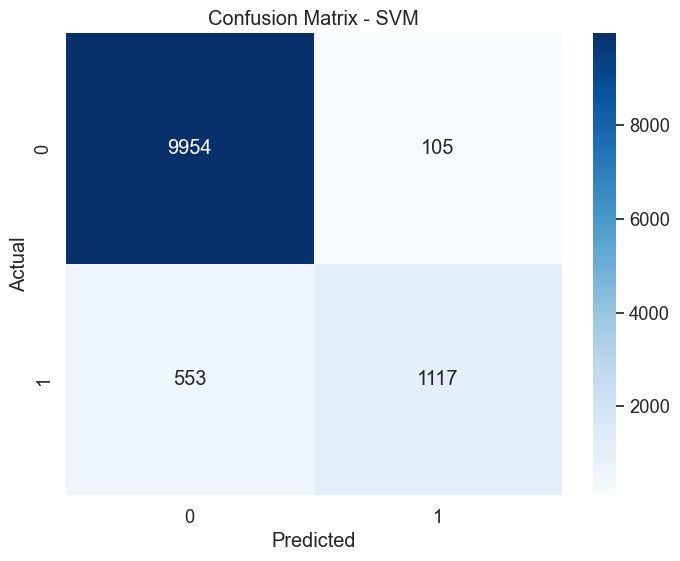

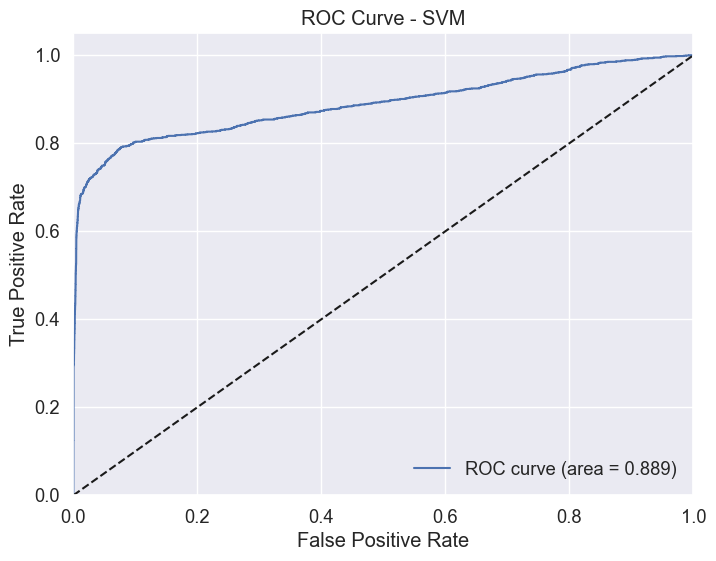

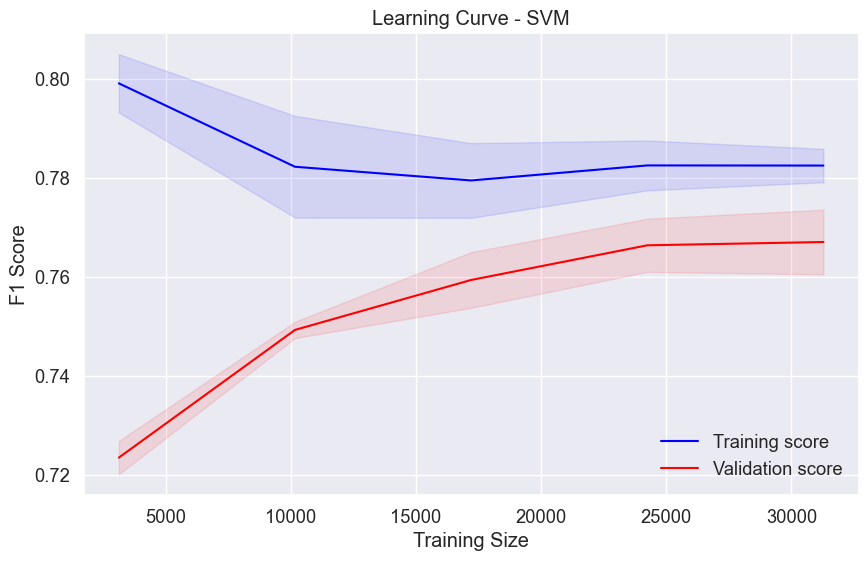

In [10]:
# Define models to evaluate
models = {
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),

    'K-Nearest Neighbors': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    
    'Neural Network': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(random_state=42, max_iter=1000))
    ]),
    
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42, probability=True))
    ])
}

# Train and evaluate all models
results = []
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    result = evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name)
    results.append(result)

In [11]:
# Compare model performances
results_df = pd.DataFrame(results)
print("\n--- Model Comparison ---")
print(results_df[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time', 'test_time']])


--- Model Comparison ---
            model_name  accuracy  precision    recall        f1   roc_auc  \
0        Decision Tree  0.911246   0.675797  0.723952  0.699046  0.833146   
1  K-Nearest Neighbors  0.931708   0.840251  0.642515  0.728198  0.871627   
2        Random Forest  0.950720   0.929245  0.707784  0.803535  0.930816   
3       Neural Network  0.945264   0.907937  0.685030  0.780887  0.924660   
4                  SVM  0.943900   0.914075  0.668862  0.772476  0.888873   

   train_time  test_time  
0    1.093252   0.075005  
1    0.224005   2.254969  
2   16.248020   0.502974  
3   47.340993   0.046000  
4  542.244546  21.523000  


<Figure size 1200x800 with 0 Axes>

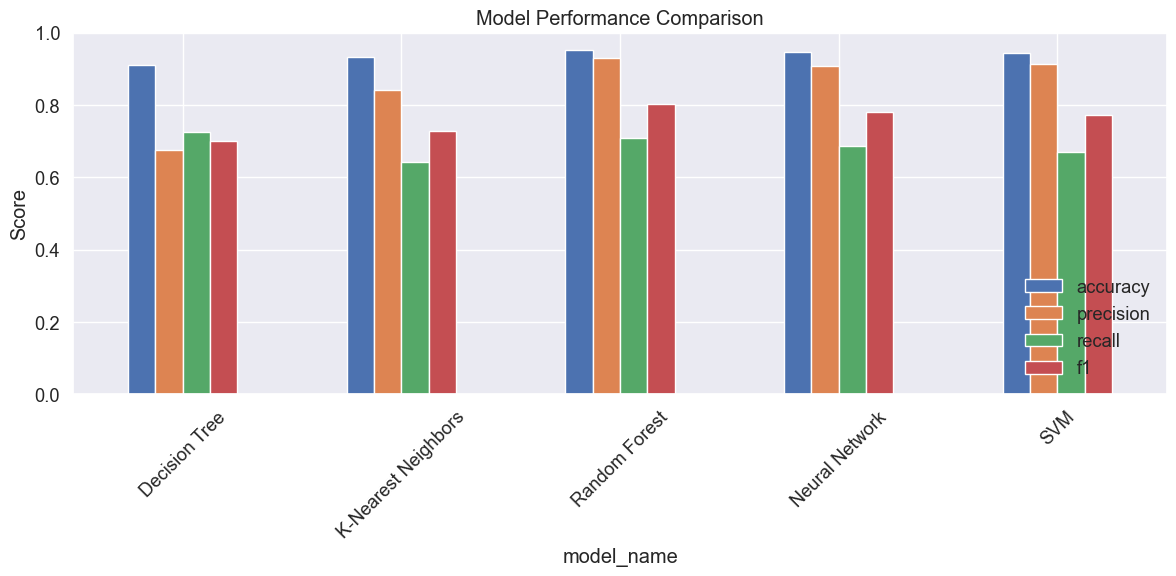

In [12]:
# Plot model comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
plt.figure(figsize=(12, 8))
results_plot = results_df.set_index('model_name')[metrics]
results_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

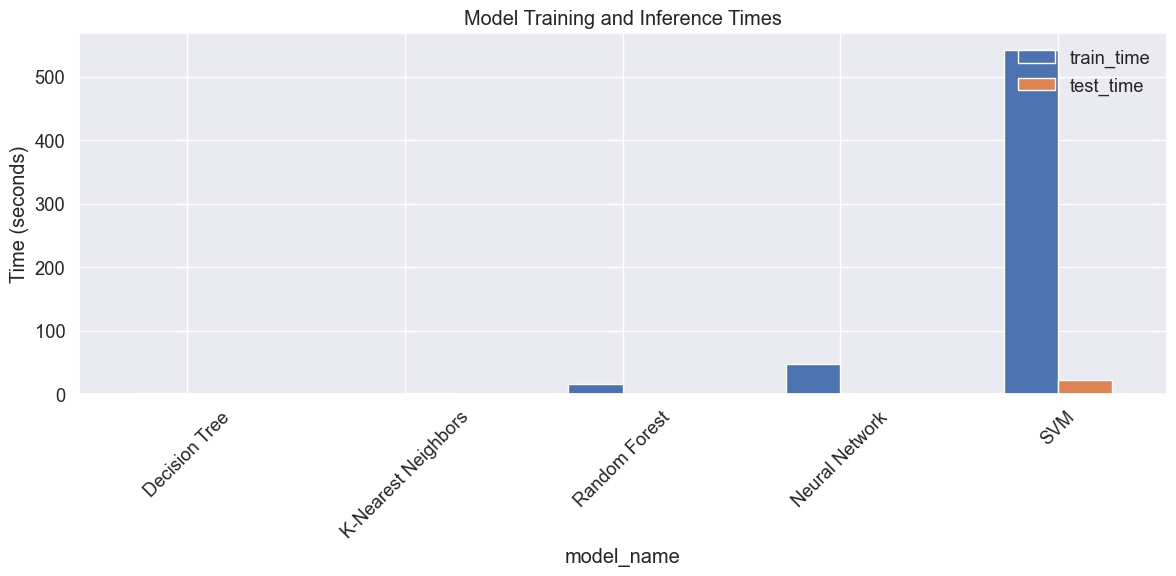

In [13]:
# Training and inference times
plt.figure(figsize=(12, 6))
times_df = results_df.set_index('model_name')[['train_time', 'test_time']]
times_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Training and Inference Times')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
# Identify the best model based on F1 score
best_model_name = results_df.loc[results_df['f1'].idxmax(), 'model_name']
print(f"\nBest performing model: {best_model_name}")

# Define parameter grid for the best model
if best_model_name == 'Decision Tree':
    #param_grid = {
    #    'classifier__max_depth': [10, None],
    #    'classifier__min_samples_split': [2, 5]
    #}
    param_grid = {
         'classifier__max_depth': [5, 10, 15, 20, None],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Random Forest':
    #param_grid = {
    #    'classifier__n_estimators': [50, 100],
    #    'classifier__max_depth': [10, None],
    #    'classifier__min_samples_split': [2, 5]
    #}
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Neural Network':
    #param_grid = {
    #    'classifier__hidden_layer_sizes': [(50,), (100,)],
    #    'classifier__alpha': [0.0001, 0.001]
    #}
    param_grid = {
         'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
         'classifier__alpha': [0.0001, 0.001, 0.01],
         'classifier__learning_rate': ['constant', 'adaptive']
    }
elif best_model_name == 'SVM':
    #param_grid = {
    #    'classifier__C': [1],
    #    'classifier__kernel': ['rbf'],
    #    'classifier__gamma': ['scale']
    #}
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto', 0.1, 1]
    }
elif best_model_name == 'K-Nearest Neighbors':
    #param_grid = {
    #    'classifier__n_neighbors': [3, 5, 7],
    #    'classifier__weights': ['uniform']
    #}
    param_grid = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }

# Perform grid search
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
grid_search = GridSearchCV(
    models[best_model_name],
    param_grid,
    cv=3,       # ideal cv=5
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best performing model: Random Forest

Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.8051



--- Tuned Random Forest Results ---
Accuracy: 0.9507
Precision: 0.9292
Recall: 0.7078
F1 Score: 0.8035
ROC AUC: 0.9308
Training time: 7.9022 seconds
Testing time: 0.2740 seconds


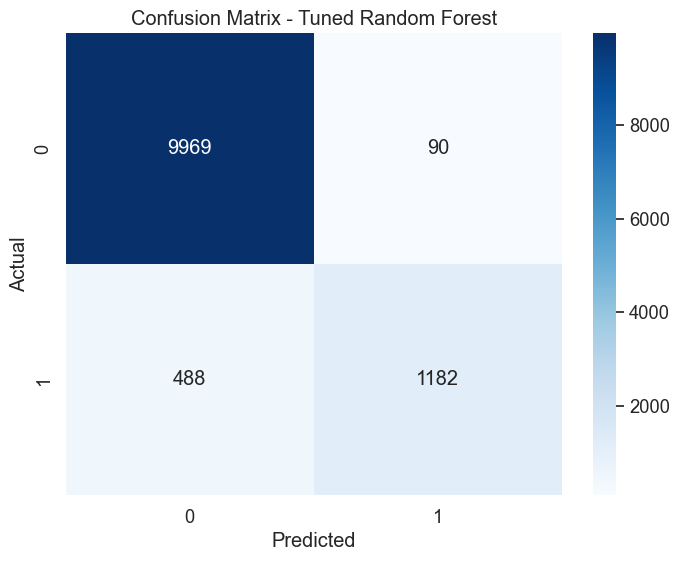

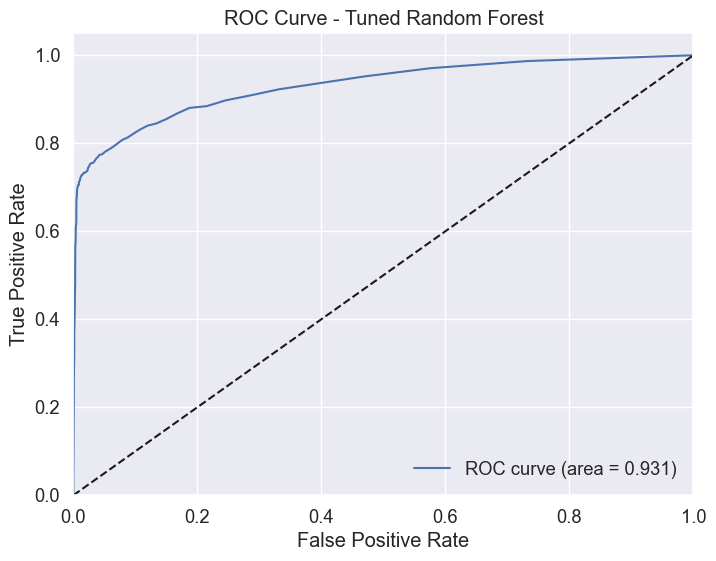

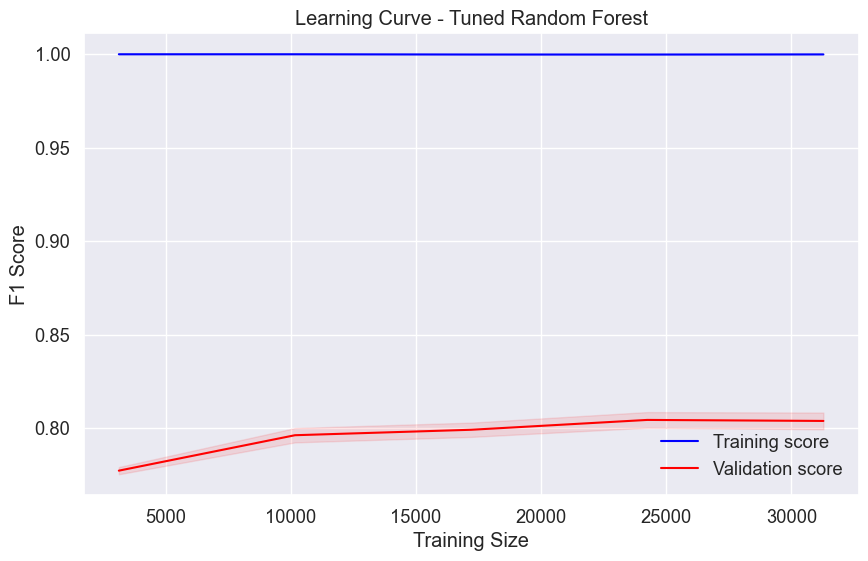

In [20]:
# Evaluate the tuned model
best_model = grid_search.best_estimator_
result = evaluate_model(best_model, X_train_split, y_train_split, X_val, y_val, f"Tuned {best_model_name}")

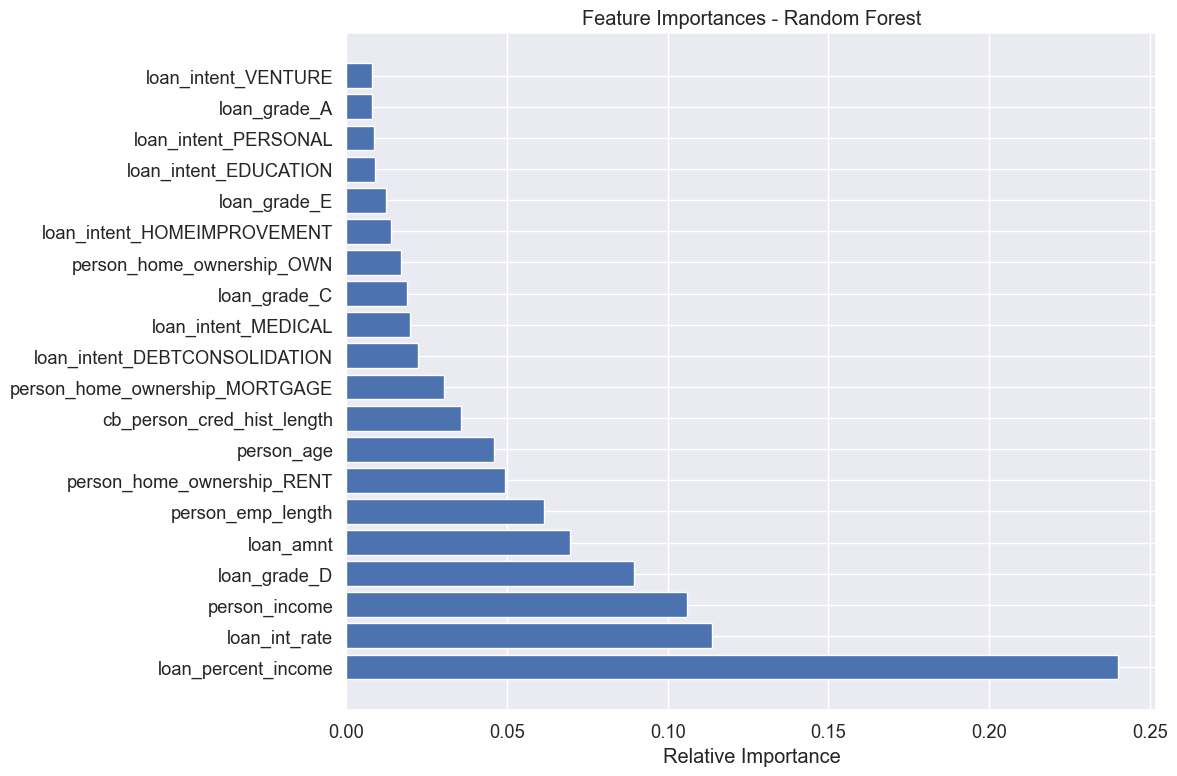

In [21]:
if best_model_name in ['Decision Tree', 'Random Forest']:
    # Extract feature names after preprocessing
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']
    
    # Apply preprocessor to get feature names
    preprocessor.fit(X_train)
    
    cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numerical_features, cat_features])
    
    # Get feature importances
    importances = classifier.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title(f"Feature Importances - {best_model_name}")
    plt.barh(range(min(20, len(indices))), importances[indices[:20]], align='center')
    plt.yticks(range(min(20, len(indices))), [feature_names[i] for i in indices[:20]])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

In [22]:
# Train the best model on the entire training set
print("\nTraining the best model on the entire training set...")
best_model.fit(X_train, y_train)

# Generate predictions
print("Generating predictions for the test set...")
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': test_predictions
})

# Save submission file
submission.to_csv('../resources/loan_approval_submission.csv', index=False)
print("Submission file created: loan_approval_submission.csv")


Training the best model on the entire training set...
Generating predictions for the test set...
Submission file created: loan_approval_submission.csv



--- Final Summary ---
Best model: Random Forest
After tuning, F1 score improved from 0.8035 to 0.8035

Class distribution in test predictions:
0    0.89355
1    0.10645
dtype: float64


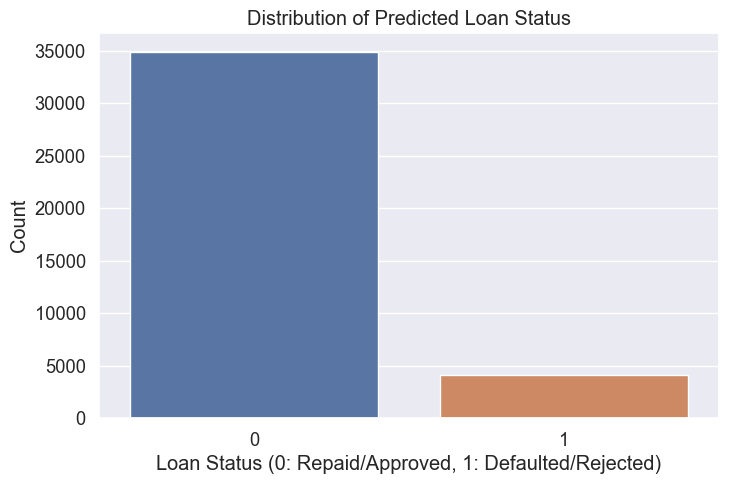


Analysis Complete!


In [23]:
print("\n--- Final Summary ---")
print(f"Best model: {best_model_name}")
if best_model_name != f"Tuned {best_model_name}":
    print(f"After tuning, F1 score improved from {results_df.loc[results_df['model_name'] == best_model_name, 'f1'].values[0]:.4f} to {result['f1']:.4f}")

# Display class distribution in predictions
print("\nClass distribution in test predictions:")
print(pd.Series(test_predictions).value_counts(normalize=True))

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=test_predictions)
plt.title('Distribution of Predicted Loan Status')
plt.xlabel('Loan Status (0: Repaid/Approved, 1: Defaulted/Rejected)')
plt.ylabel('Count')
plt.show()

print("\nAnalysis Complete!")